## Intro and setup

In two previous articles we scraped _Rolling Stone_'s list of the "Greatest 500 songs of all time", and retrieved audio features for each of them from Spotify's API (with the help of the amazing ```spotipy``` library). Now that we have all the data we can start doing some analysis. 
For example, here are some questions that sprung to my mind when I first conceived of running this analysis:

- is the "greatness" of a song somehow linked to its popularity?
- which artists are featured more often?
- how do the songs' features evolve in time?
- are there any characteristics that somehow are more common in the "greatest songs of all time"?
- ...

In what follows I will answer these questions and more with the help of data analysis and visualization.

Note that you can download the dataset from Kaggle and that the source code for this article is available as a notebook in the following GitHub repo.

Let's get started by importing some libraries and loading the data in `pandas`.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
sns.set_style('white')
#plt.xkcd() # uncomment this: it's fun
%matplotlib inline
%config InlineBackend.figure_format='retina'

Let's take a look at our dataframe.

In [4]:
df = pd.read_csv('rollingstone.csv')
df.head()

,Unnamed: 0,Artist,Title,Writers,Producer,Year,Spotify id,Popularity,danceability,energy,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,Smokey Robinson and the Miracles,Shop Around,"Berry Gordy, Robinson",Gordy,60,77Z1pij1PpjhlzZnzBM86G,14,0.562,0.689,...,0.7530,0.875,132.448,audio_features,77Z1pij1PpjhlzZnzBM86G,spotify:track:77Z1pij1PpjhlzZnzBM86G,https://api.spotify.com/v1/tracks/77Z1pij1Ppjh...,https://api.spotify.com/v1/audio-analysis/77Z1...,170560,4
1,1,Weezer,Buddy Holly,Rivers Cuomo,Ric Ocasek,94,3mwvKOyMmG77zZRunnxp9E,73,0.556,0.920,...,0.1170,0.771,121.138,audio_features,3mwvKOyMmG77zZRunnxp9E,spotify:track:3mwvKOyMmG77zZRunnxp9E,https://api.spotify.com/v1/tracks/3mwvKOyMmG77...,https://api.spotify.com/v1/audio-analysis/3mwv...,159227,4
2,2,The Rolling Stones,Miss You,"Mick Jagger, Keith Richards",The Glimmer Twins,78,3hJLKtTpgct9Y9wKww0BiR,69,0.795,0.710,...,0.3440,0.845,109.689,audio_features,3hJLKtTpgct9Y9wKww0BiR,spotify:track:3hJLKtTpgct9Y9wKww0BiR,https://api.spotify.com/v1/tracks/3hJLKtTpgct9...,https://api.spotify.com/v1/audio-analysis/3hJL...,288667,4
3,3,Bruce Springsteen,The Rising,Springsteen,Brendan O'Brien,02,2czBvzOv3TvnyoW7Ozo7fP,57,0.499,0.761,...,0.0895,0.326,110.186,audio_features,2czBvzOv3TvnyoW7Ozo7fP,spotify:track:2czBvzOv3TvnyoW7Ozo7fP,https://api.spotify.com/v1/tracks/2czBvzOv3Tvn...,https://api.spotify.com/v1/audio-analysis/2czB...,287040,4
4,4,Jackson Browne,Running on Empty,Browne,Browne,77,6aqm56xP40foYBBtAWWrnY,68,0.541,0.711,...,0.7190,0.588,136.580,audio_features,6aqm56xP40foYBBtAWWrnY,spotify:track:6aqm56xP40foYBBtAWWrnY,https://api.spotify.com/v1/tracks/6aqm56xP40fo...,https://api.spotify.com/v1/audio-analysis/6aqm...,291893,4


There's a bunch of columns we surely won't be needing: might as well get rid of them.

In [5]:
df = df.drop(['Unnamed: 0', 'Spotify id', 'id', 'uri', 'track_href', 'analysis_url', 'type'], axis=1)

In [6]:
df.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,63.288000,0.555158,0.603755,5.036000,-9.270874,0.762000,0.062913,0.344240,0.040539,0.200092,0.636898,122.098836,227655.942000,3.936000
std,13.686039,0.153666,0.215517,3.513887,3.356454,0.426286,0.060328,0.299551,0.137610,0.182914,0.231517,28.839805,90543.688185,0.253046
min,3.000000,0.104000,0.019200,0.000000,-24.385000,0.000000,0.024900,0.000005,0.000000,0.024400,0.033200,66.344000,85360.000000,3.000000
25%,57.750000,0.443000,0.452000,2.000000,-11.170500,1.000000,0.032075,0.051275,0.000000,0.088525,0.472000,102.492750,164146.750000,4.000000
50%,66.000000,0.551500,0.607000,5.000000,-9.211500,1.000000,0.040950,0.271500,0.000063,0.128500,0.663500,118.364500,199084.500000,4.000000
75%,73.000000,0.654250,0.770250,8.000000,-6.774750,1.000000,0.063600,0.605500,0.003370,0.237250,0.841250,136.911000,274223.000000,4.000000
max,86.000000,0.947000,0.989000,11.000000,-1.609000,1.000000,0.405000,0.989000,0.949000,0.971000,0.985000,203.871000,703373.000000,5.000000


## Who are the most voted artists?

Let's plot the top 10 artists by number of mentions, to begin.

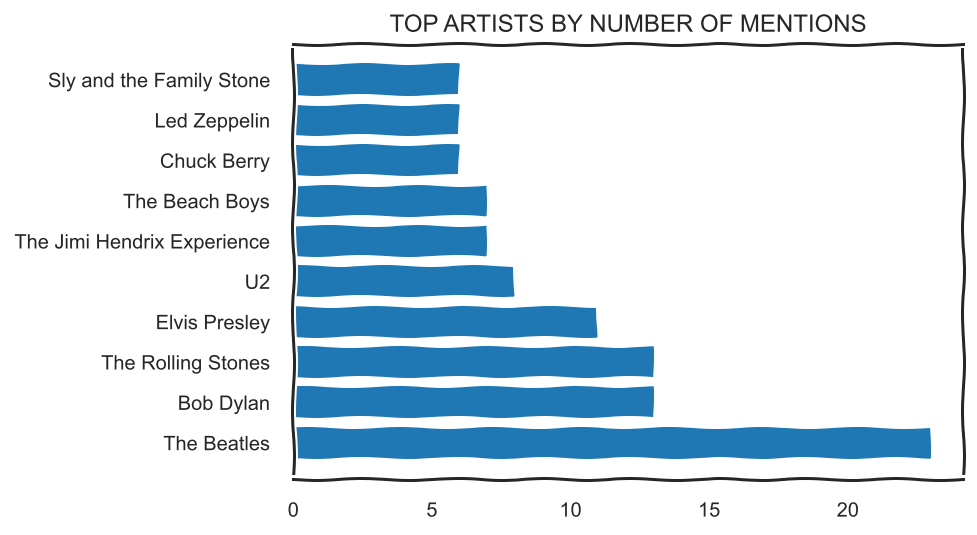

In [134]:
top_10_artists = df['Artist'].value_counts().head(10)
plt.barh(top_10_artists.index, top_10_artists)
plt.title("Top artists by number of mentions".upper())
plt.show()

No huge surprises here. Let's move on to another question.

# Is popularity correlated to ranking?

One might wonder whether the 'best' songs - i.e. the ones ranked higher by *Rolling Stone* are also the most popular; viceversa, it is legitimate to ask whether a song's (relatively) low ranking makes it less popular. Let's check by adding a `Ranking` column to our dataframe and correlating it to the `popularity` column. 


In [135]:
df['Ranking'] = np.arange(499,-1, -1)

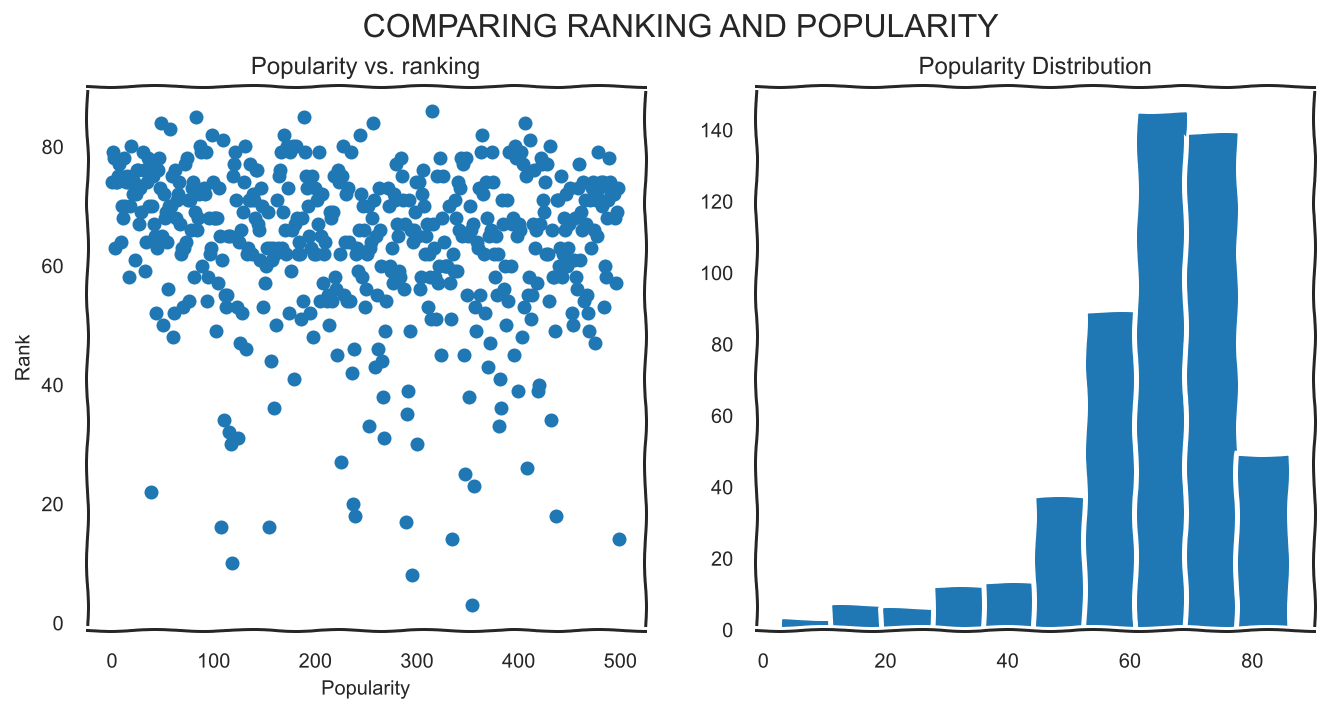

In [160]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
fig.suptitle('COMPARING RANKING AND POPULARITY', fontsize=16)
ax1.scatter(df['Ranking'], df['Popularity'])
ax1.set_title('Popularity vs. ranking')
ax1.set_xlabel('Popularity')
ax1.set_ylabel('Rank')
ax2.hist(df['Popularity'])
ax2.set_title('Popularity Distribution')
plt.show()

While most songs seem to be fairly popular (as evidenced by the skewness of the distribution) - ranking is not correlated with popularity. Let's inspect the most popular 10 songs as well as the 10 highest ranked's popularity scores.

In [137]:
most_popular = df.sort_values(by='Popularity', axis =0, ascending=False).iloc[:, :6]
most_popular.head(10)

,Artist,Title,Writers,Producer,Year,Popularity
184,Tina Turner,What's Love Got to Do With It,"Terry Britten, Graham Lyle",Britten,84,86
310,AC/DC,Back in Black,"Angus Young, Malcolm Young, Brian Johnson",Mutt Lange,80,85
416,The Police,Every Breath You Take,Sting,Hugh Padgham,83,85
93,Lynyrd Skynyrd,Sweet Home Alabama,"Ed King, Gary Rossington, Ronnie Van Zant",Al Kooper,74,84
242,AC/DC,Highway to Hell,"Angus Young, Malcolm Young, Bon Scott",Robert John Lange,79,84
451,The Eagles,Hotel California,"Don Felder, Glenn Frey, Don Henley",Bill Szymczyk,76,84
442,Michael Jackson,Billie Jean,Jackson,"Jackson, Quincy Jones",83,83
401,Creedence Clearwater Revival,Fortunate Son,John Fogerty,Fogerty,69,82
255,Elton John,Rocket Man,"John, Bernie Taupin",Gus Dudgeon,72,82
135,Eurythmics,Sweet Dreams (Are Made of This),"Annie Lennox, Dave Stewart",Stewart,83,82


Now let's look at the highest ranked songs' popularity scores

In [138]:
df.sort_values(by="Ranking", axis=0).iloc[:, :6].head(10)

,Artist,Title,Writers,Producer,Year,Popularity
499,Bob Dylan,Like a Rolling Stone,Dylan,Tom Wilson,65,74
498,The Rolling Stones,(I Can't Get No) Satisfaction,"Mick Jagger, Keith Richards",Andrew Loog Oldham,65,79
497,John Lennon,Imagine,John Lennon,"Lennon, Phil Spector, Yoko Ono",71,78
496,Marvin Gaye,What's Going On,"Gaye, Renaldo Benson, Al Cleveland",Gaye,71,63
495,Aretha Franklin,Respect,Otis Redding,Jerry Wexler,67,74
494,The Beach Boys,Good Vibrations,"Brian Wilson, Mike Love",Wilson,66,74
493,Chuck Berry,Johnny B. Goode,Chuck Berry,Leonard and Phil Chess,58,75
492,The Beatles,Hey Jude,"John Lennon, Paul McCartney",George Martin,68,77
491,Nirvana,Smells Like Teen Spirit,Kurt Cobain,Butch Vig,91,75
490,Ray Charles,What'd I Say,Charles,"Ahmet Ertegun, Jerry Wexler",59,64


These results are not intuitive (at least to me). I would have expected, say, the Rolling Stones' *Satisfaction* to be way more popular than the Eurythmics *Sweet dreams*. It might be worth looking into how the `popularity` score is calculated by Spotify before drawing any conclusions. Spotify's API [documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-tracks) states that: 
>The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

Maybe this has to do with duplicate tracks?

# How are the audio features distributed?

As I mentioned earlier, for each of the songs we can inspect it's [audio features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features). Let's explore the distribution of the audio features (I'll plot both a standard histogram and a violinplot).

**acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**duration_ms**: The duration of the track in milliseconds.

**energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.


**instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

**liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

**mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

**time_signature**: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

**valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative

Let's plot the features and see if we can gain any insights.

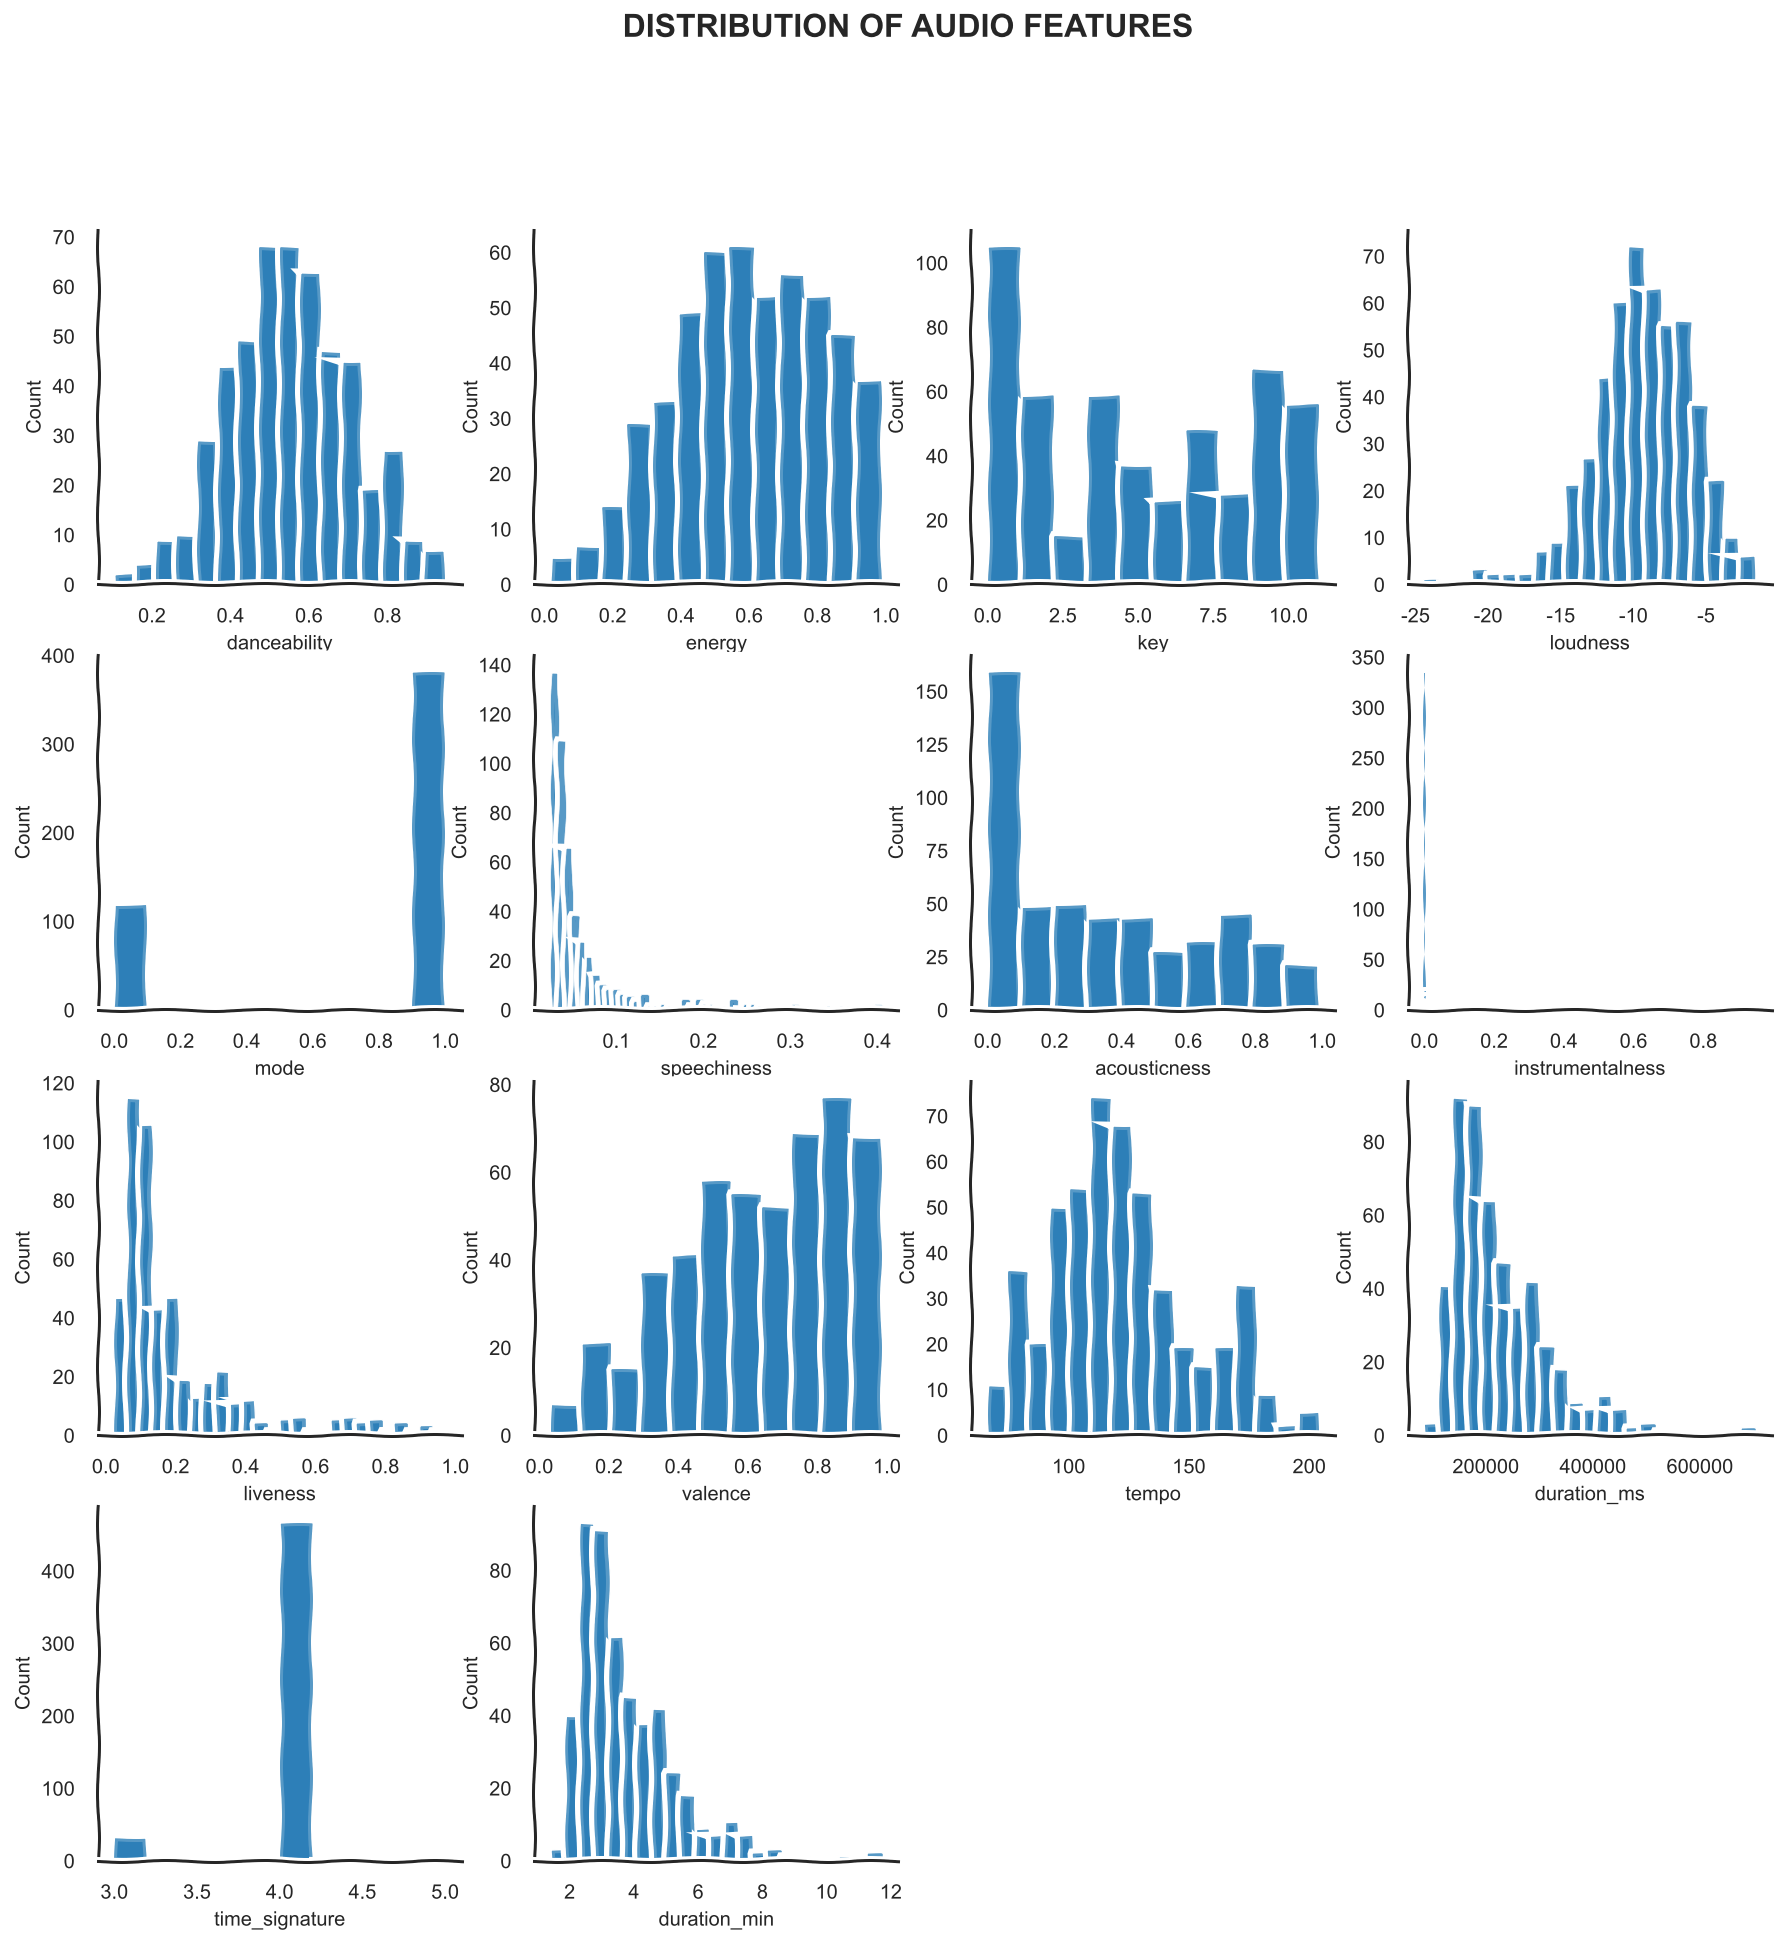

In [140]:
# create a dataframe with just the features so we can iterate over it
features = df.copy().iloc[:, 6:19]

# convert duration column from milliseconds to seconds
features['duration_min'] = round(features['duration_ms']/1000/60, 2)
features.drop(['duration_ms'], axis=1)

# setup subplots
rows = 4
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))
titles = features.columns.values
fig.suptitle('DISTRIBUTION OF AUDIO FEATURES', fontweight='bold', fontsize=16)
# counter to choose which feature to plot
title_no = 0

# given that we have odd size let's deactivate plots that go over array size
while title_no < titles.size:
    for row in range(rows):
        for col in range(cols):
            if title_no >= titles.size:
                ax[row, col].set_visible(False)
            else:
                sns.histplot(features[
                titles[title_no]],
                             kde=False, ax=ax[row, col])
                sns.despine()
                title_no += 1

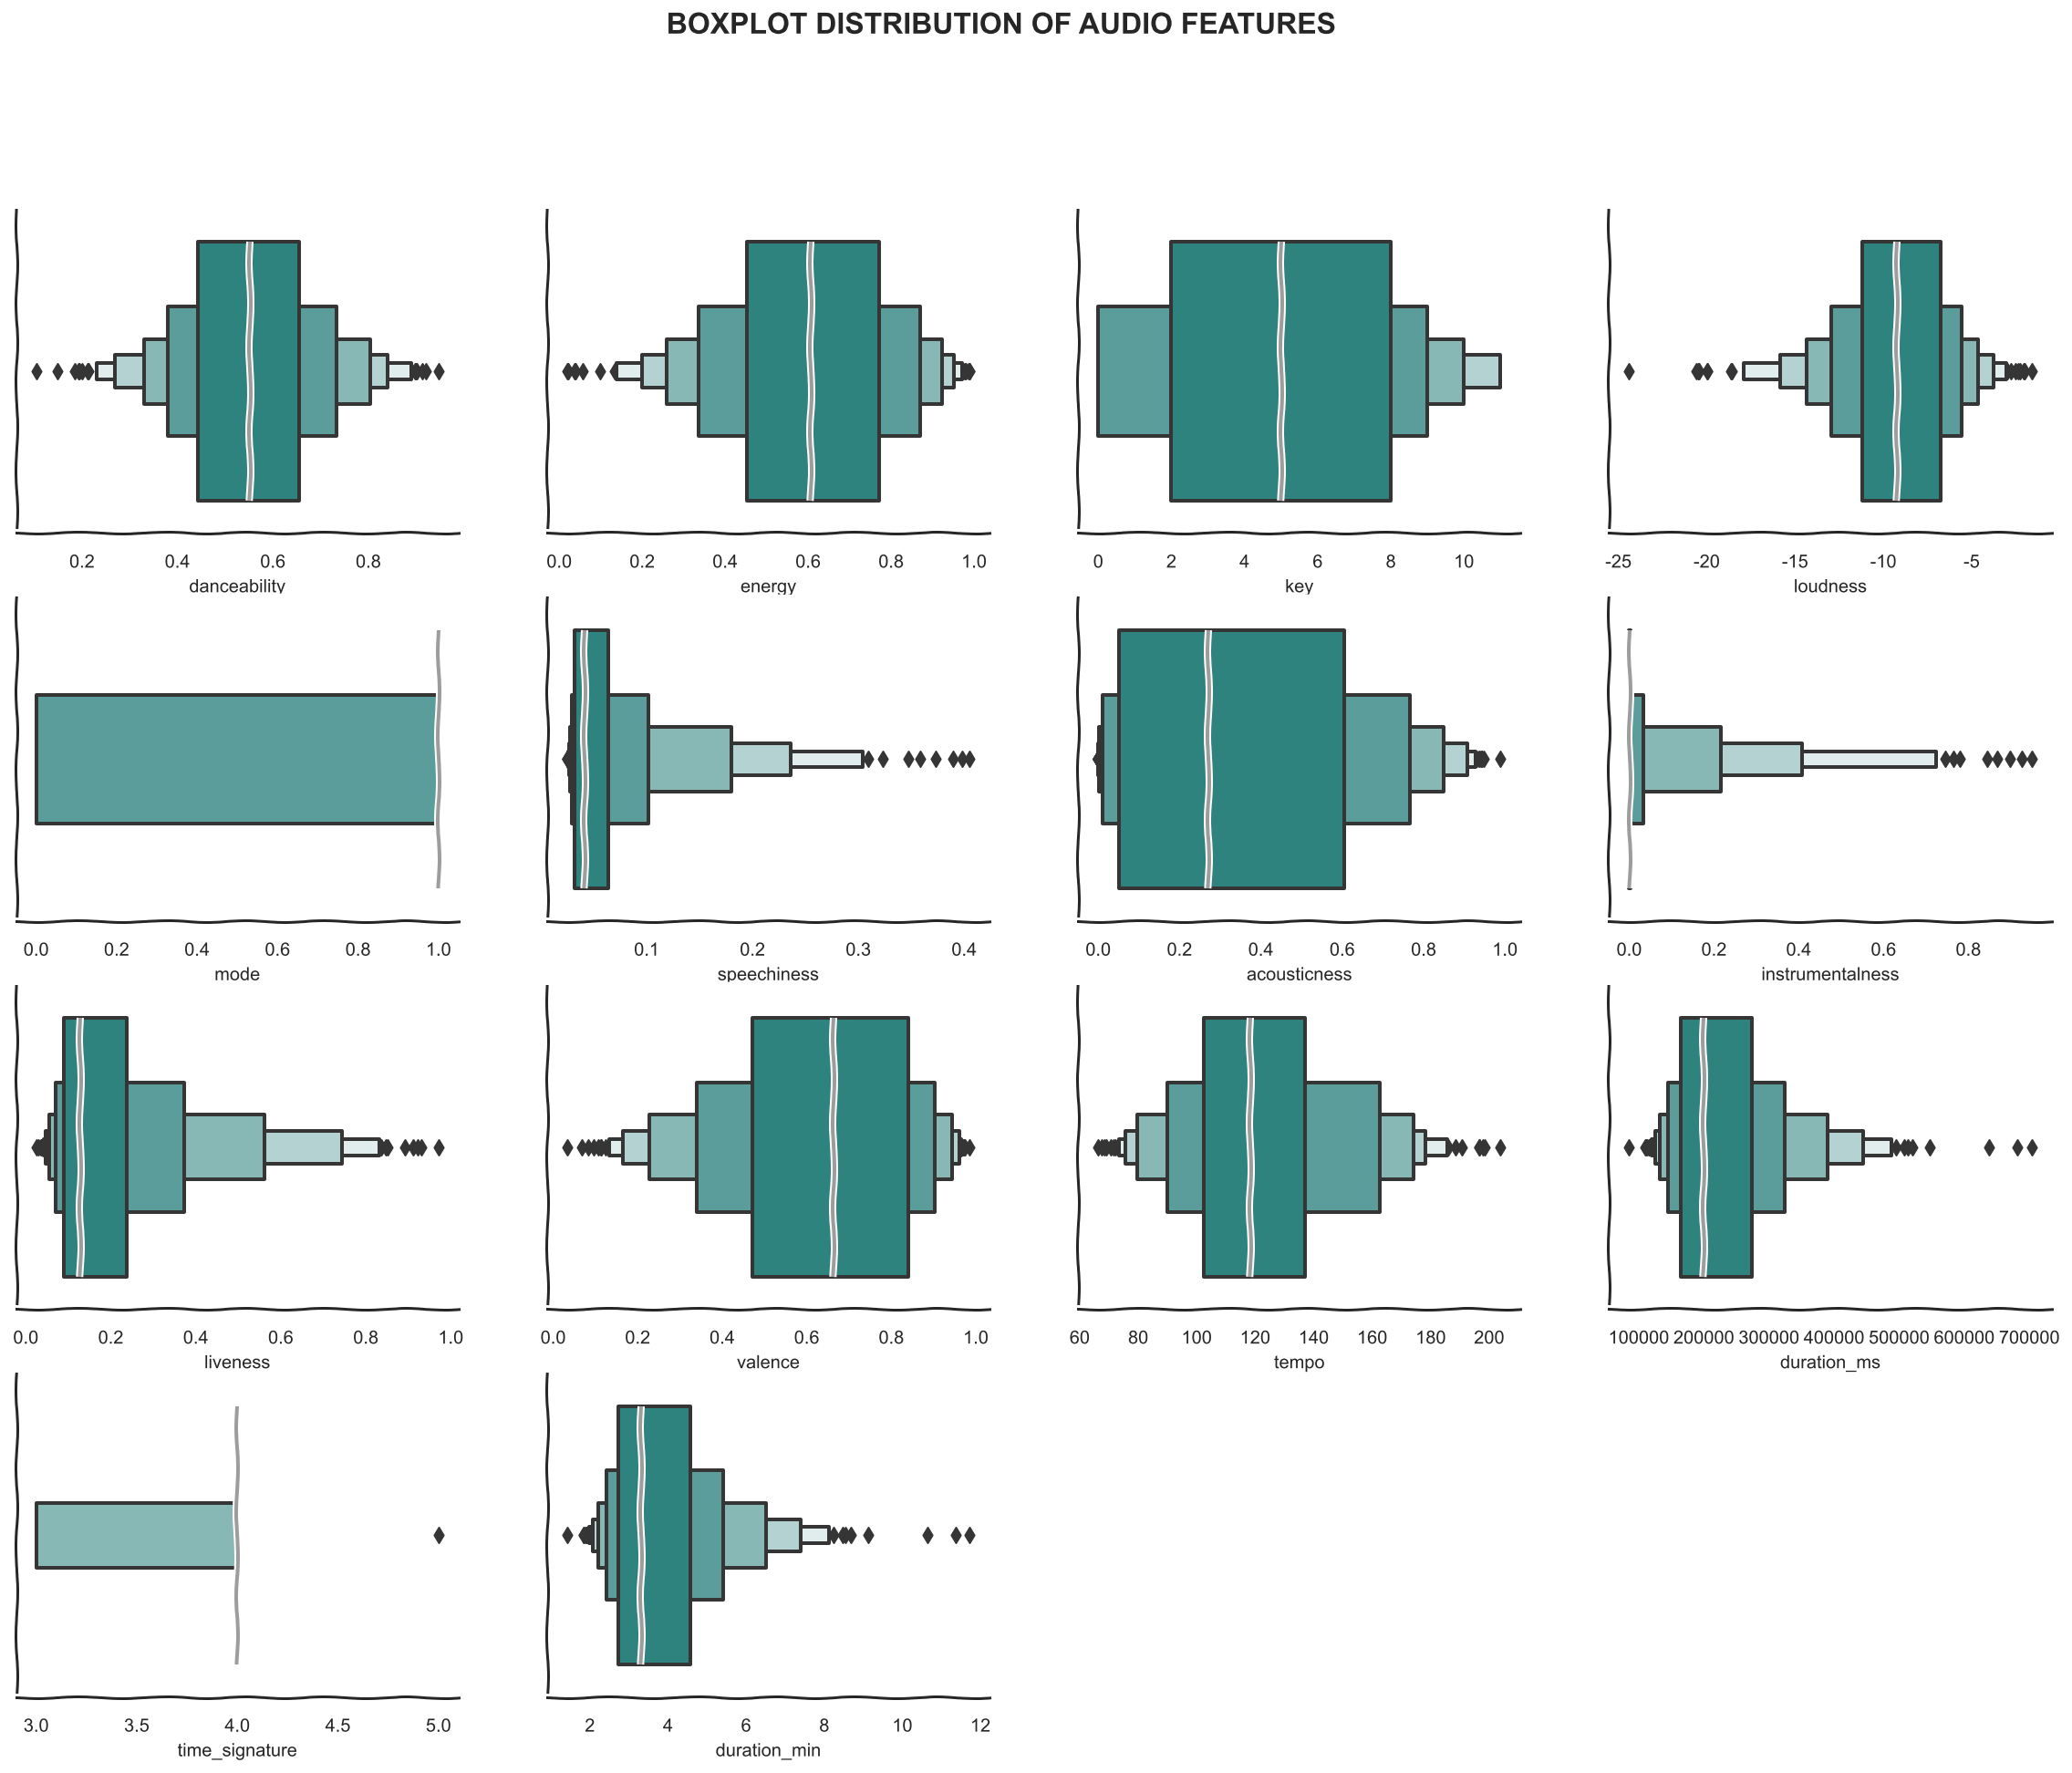

In [141]:
rows = 4
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(20,15)) #  
titles = features.columns.values
fig.suptitle('BOXPLOT DISTRIBUTION OF AUDIO FEATURES', fontweight= 'bold', fontsize=16)
# counter to choose which feature to plot
title_no = 0 

# given that we have odd size let's deactivate plots that go over array size
while title_no < titles.size:
        for row in range(rows):
            for col in range(cols):
                if title_no >= titles.size:
                    ax[row,col].set_visible(False)
                else:
                    sns.boxenplot(x=features[titles[title_no]], ax=ax[row,col], palette="viridis")
                    sns.despine()
                    title_no +=1

A few quick takeaways:
* **danceability** seems to be very evenly distributed;
* **C** is the prevalent key;
* **major** is by far the prevalent **mode** and **4/4** dominates **time signatures**;
* **duration** is mostly comprised between **2 and 5 minutes**;
* there is some tendency towards 'happy' (**valence**) and 'energetic' (**liveliness**);
* both **speechiness** and **acousticness** receive a penalty.

One thing that should bother us is that `mode` and `key` have been decoupled. Let's crete a categorical class for the actual key instead, and then take a closer look at the same data by visualizing it with boxplots.

In [142]:
keys = ["C", "C#/Db", "D", "D#/Eb", "E", "F", "F#/Gb", "G", "G#/Ab", "A", "A#/Bb", "B"]
keys_dict = {key : value for key, value in zip(range(12), keys)}
features["key_mode"] = features[["key", "mode"]].apply(lambda x: keys_dict[x[0]] + (" min" if x[1]==0 else " Maj"), axis=1)

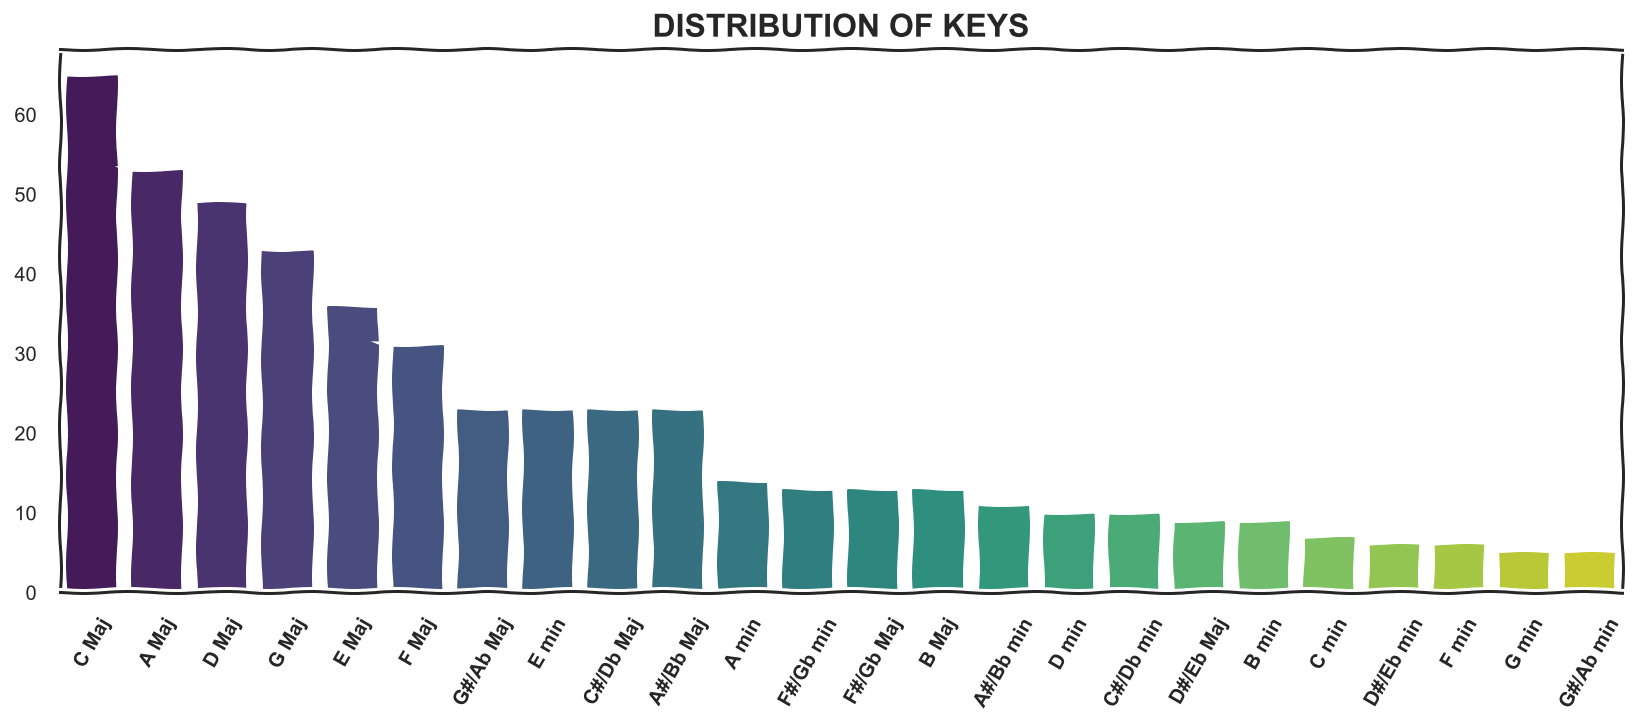

In [143]:
key_counts = features["key_mode"].value_counts()
plt.figure(figsize=(14, 5))
sns.barplot(x=key_counts.index, y=key_counts.values, data=features, palette="viridis")
plt.xticks(rotation=60, fontweight="bold")
plt.title("Distribution of keys".upper(), fontweight="bold", fontsize=16)
plt.show()

## By the way: is D minor the saddest of all keys? Or: Why Nigel Tufnel is wrong.

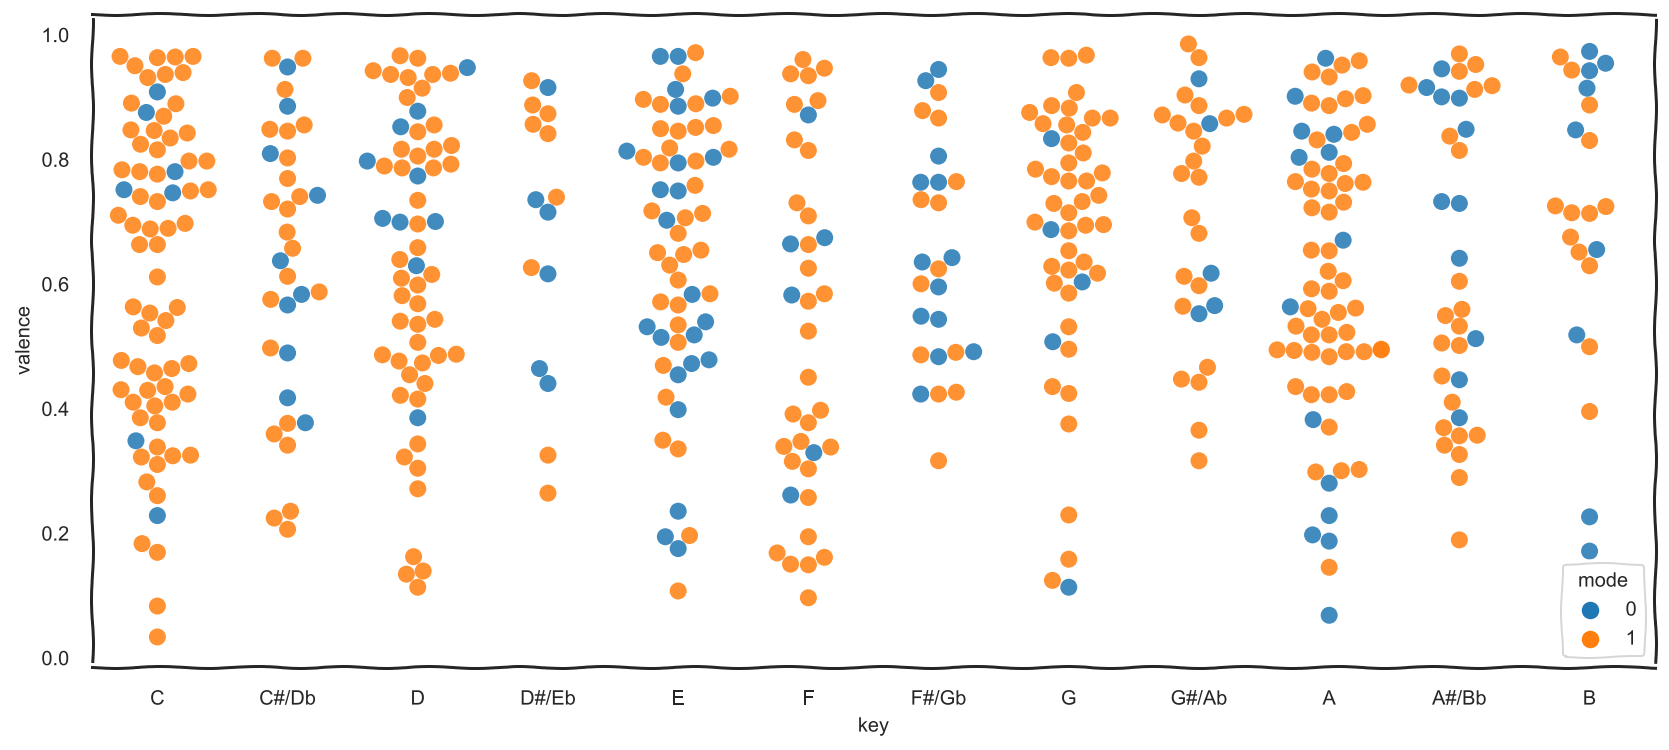

In [149]:
fig = plt.figure(figsize=(14, 6))
sns.swarmplot(y="valence", x="key", hue="mode", data=features, size=8.5, alpha=0.85)
g = plt.xticks(ticks=range(0, 12), labels=keys_dict.values(), rotation=0)
plt.show()

There aren't actually that many sad songs in D minor, at least among the "greatest 500 of all times" - if anything it seems that E minor and A minor are sadder! (Remember:  tracks with low valence sound more negative. Minor mode is 0.)

Let's also check how these features correlate with themselves and with ranking.

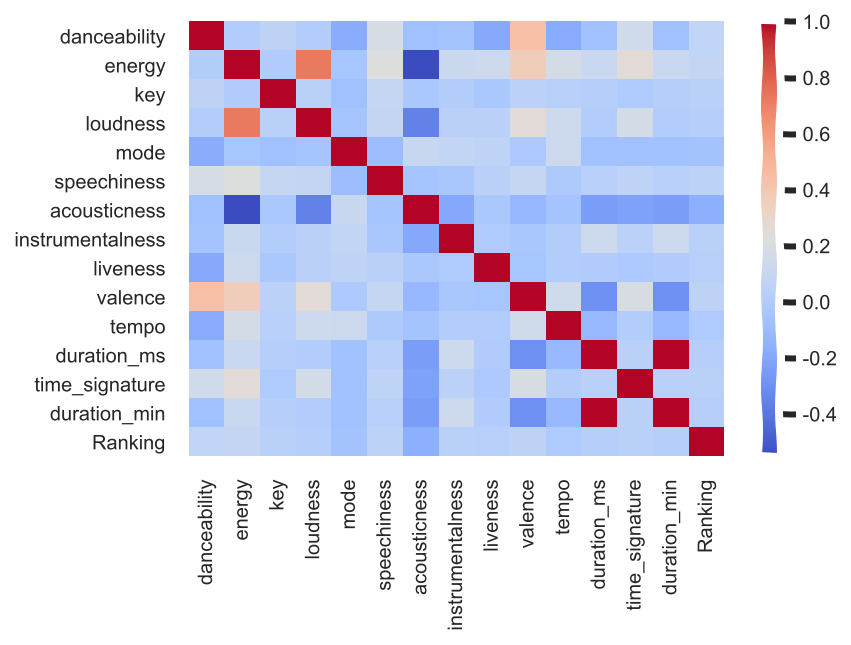

In [161]:
data = pd.concat([features, df['Ranking']], axis=1)
sns.heatmap(data.corr(), fmt="g", cmap='coolwarm')
plt.show()

Perhaps unsurprisingly no one feature seems to be a significant predictor of rank: acousticness and instrumentalness receive a modest penalty, as noted.

## How does the dataset evolve with time?

In [162]:
df.loc[478, "Year"] = 63

In [163]:
def convert_to_full_year(year):
    try:
        year = str(year)
        if int(year[0]) in [0, 1, 2]:
            year = "20" + year
        else:
            year = "19" + year
        return int(year)
    except Exception:
        return np.nan

In [164]:
def full_year_to_decade(year):
    try:
        year = (year % 100 // 10) * 10
        return str(year)
    except Exception:
        return np.nan

In [165]:
a = convert_to_full_year(df.loc[3]["Year"])
df.loc[3]["Year"], a

('02', 2002)

In [166]:
df["full_year"] = df["Year"].apply(convert_to_full_year)
df["decade"] = df["full_year"].apply(full_year_to_decade)


In [167]:
decades= df.groupby("decade").count()

In [168]:
decades

,Artist,Title,Writers,Producer,Year,Popularity,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Ranking,full_year
decade,,,,,,,,,,,,,,,,,,,,,
0.0,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
40.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
50.0,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
60.0,195,195,195,195,195,195,195,195,195,195,...,195,195,195,195,195,195,195,195,195,195
70.0,131,131,131,131,131,131,131,131,131,131,...,131,131,131,131,131,131,131,131,131,131
80.0,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,55
90.0,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
nan,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


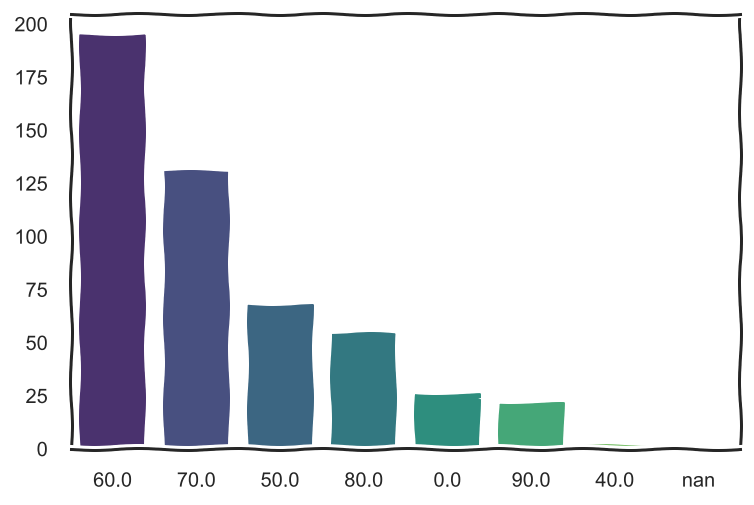

In [169]:
sns.barplot(x=df["decade"].value_counts().index, y=df["decade"].value_counts().values, data=df, palette="viridis")
plt.show()

## Linear Reg

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [50]:
X = np.array(features.values)

In [51]:
y = df["Ranking"].values

In [52]:
m = LinearRegression()

In [53]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

ValueError: could not convert string to float: 'G Maj'

In [54]:
reg = m.fit(X, y)

ValueError: could not convert string to float: 'G Maj'

In [55]:
reg.coef_, reg.intercept_

NameError: name 'reg' is not defined

In [170]:
print(f"feature\t\t\t coef")
print("-"*40)
for feature, coef in list(zip(features.columns, reg.coef_)):
    print(f"{feature:20}\t {coef:.3f}")

feature			 coef
----------------------------------------


NameError: name 'reg' is not defined

In [171]:
features["decade"] = df["decade"]

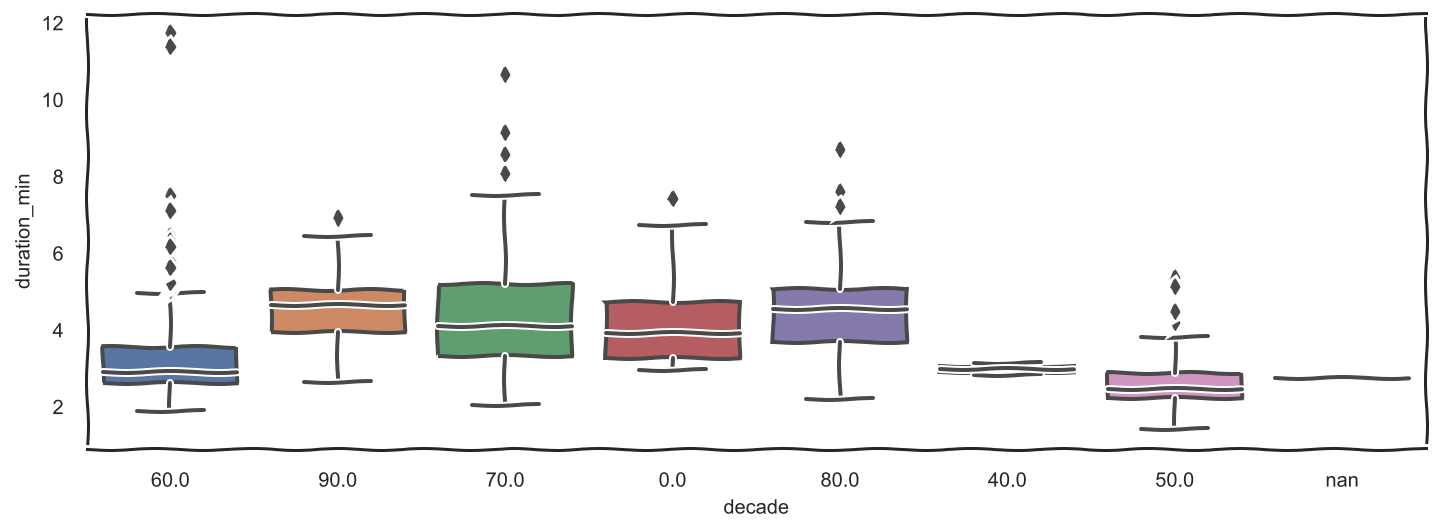

In [173]:
plt.figure(figsize=(12,4))
sns.boxplot(data=features, x="decade", y="duration_min", palette="deep")
plt.show()

In [174]:
df[df["duration_ms"] == max(df["duration_ms"])]

,Artist,Title,Writers,Producer,Year,Popularity,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Ranking,full_year,decade
164,The Doors,The End,"John Densmore, Robbie Krieger, Ray Manzarek, J...",Paul Rothchild,67,62,0.347,0.302,0,-12.104,...,0.163,0.000092,0.14,0.0332,105.702,703373,4,335,1967.0,60.0


In [175]:
df[df["duration_ms"] == min(df["duration_ms"])]

,Artist,Title,Writers,Producer,Year,Popularity,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Ranking,full_year,decade
392,Buddy Holly and the Crickets,Not Fade Away,"Holly, Norman Petty",Petty,57,16,0.642,0.801,7,-10.338,...,0.923,0.0431,0.105,0.833,111.527,85360,4,107,1957.0,50.0


In [176]:
features.max()

danceability            0.947
energy                  0.989
key                        11
loudness               -1.609
mode                        1
speechiness             0.405
acousticness            0.989
instrumentalness        0.949
liveness                0.971
valence                 0.985
tempo                 203.871
duration_ms            703373
time_signature              5
duration_min            11.72
key_mode            G#/Ab min
decade                    nan
dtype: object

In [177]:
df[df["valence"] == min(df["valence"])]

,Artist,Title,Writers,Producer,Year,Popularity,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Ranking,full_year,decade
164,The Doors,The End,"John Densmore, Robbie Krieger, Ray Manzarek, J...",Paul Rothchild,67,62,0.347,0.302,0,-12.104,...,0.163,0.000092,0.14,0.0332,105.702,703373,4,335,1967.0,60.0


In [178]:
a = df.iloc[(df["duration_ms"]-df["duration_ms"].mean()).abs().argsort()]

In [179]:
df["duration_ms"].mean()

227655.942

In [180]:
a

,Artist,Title,Writers,Producer,Year,Popularity,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Ranking,full_year,decade
274,Muddy Waters,Hoochie Coochie Man,Willie Dixon,"Leonard and Phil Chess, Dixon",54,27,0.584,0.399,2,-10.115,...,0.78700,0.067300,0.7020,0.6990,105.946,228000,3,225,1954.0,50.0
101,The Temptations,Just My Imagination,"Norman Whitfield, Barrett Strong",Whitfield,71,65,0.425,0.242,0,-15.424,...,0.88000,0.011800,0.1950,0.4770,92.472,228160,4,398,1971.0,70.0
112,U2,Pride (In the Name of Love),"Bono, the Edge, Adam Clayton, Larry Mullen Jr.","Brian Eno, Daniel Lanois",84,60,0.458,0.843,4,-7.201,...,0.00135,0.000296,0.7780,0.7130,105.701,228427,4,387,1984.0,80.0
5,The Rolling Stones,Brown Sugar,"Mick Jagger, Keith Richards",Jimmy Miller,71,72,0.633,0.934,0,-3.594,...,0.21900,0.000210,0.0592,0.9630,128.606,228667,4,494,1971.0,70.0
466,The Righteous Brothers,You've Lost That Lovin' Feelin',"Phil Spector, Barry Mann, Cynthia Weil",Spector,64,64,0.369,0.305,1,-14.303,...,0.52200,0.000000,0.0579,0.3760,94.791,226453,4,33,1964.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,Prince and the Revolution,Purple Rain,Prince,Prince,84,76,0.367,0.452,10,-10.422,...,0.03530,0.002280,0.6890,0.1890,113.066,520787,4,143,1984.0,80.0
307,Lynyrd Skynyrd,Free Bird,"Allen Collins, Ronnie Van Zant",Al Kooper,73,73,0.249,0.834,0,-8.210,...,0.07380,0.000095,0.0924,0.3380,118.223,547107,4,192,1973.0,70.0
119,Television,Marquee Moon,Tom Verlaine,Andy Johns,77,62,0.490,0.536,7,-10.830,...,0.03910,0.371000,0.1160,0.7320,118.008,638427,4,380,1977.0,70.0
313,Bob Dylan,Desolation Row,Dylan,Bob Johnston,65,51,0.432,0.605,4,-6.941,...,0.67300,0.000000,0.1290,0.6470,109.227,681400,4,186,1965.0,60.0


https://stackoverflow.com/questions/30112202/how-do-i-find-the-closest-values-in-a-pandas-series-to-an-input-number

In [181]:
def sort_by_closest_to_mean(frame, column):
    mean = df[column].mean()
    return frame.iloc[(df[column]-mean).abs().argsort()]

In [182]:
valence_mean_df = sort_by_closest_to_mean(df, "valence")

In [183]:
valence_mean_df

,Artist,Title,Writers,Producer,Year,Popularity,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Ranking,full_year,decade
411,The Mamas and the Papas,California Dreamin',John and Michelle Phillips,Lou Adler,65,79,0.552,0.608,1,-9.786,...,0.35200,0.000000,0.0533,0.6370,112.367,162373,4,88,1965.0,60.0
260,Afrika Bambaataa and the Soul Sonic Force,Planet Rock,"Bambaataa, John Robie, the Soul Sonic Force","Bambaataa, Arthur Baker",82,18,0.855,0.927,7,-5.782,...,0.04970,0.000000,0.0923,0.6350,126.482,454573,4,239,1982.0,80.0
92,Metallica,Enter Sandman,"James Hetfield, Lars Ulrich, Kirk Hammett","Bob Rock, Hetfield, Ulrich",91,75,0.579,0.824,6,-8.710,...,0.00206,0.009030,0.0590,0.6350,123.331,331573,4,407,1991.0,90.0
421,The Byrds,Mr. Tambourine Man,Bob Dylan,Terry Melcher,65,66,0.456,0.470,2,-9.564,...,0.51300,0.000038,0.4440,0.6390,120.336,149467,4,78,1965.0,60.0
286,The Beach Boys,"Caroline, No","Brian Wilson, Tony Asher",Wilson,66,50,0.402,0.426,10,-9.662,...,0.77500,0.000006,0.1750,0.6410,75.866,173933,4,213,1966.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,The Stooges,I Wanna Be Your Dog,"Dave Alexander, Ron Asheton, Scott Asheton, Ig...",John Cale,69,62,0.527,0.871,4,-8.708,...,0.02290,0.155000,0.4190,0.1070,120.722,188560,4,444,1969.0,60.0
232,Randy Newman,Sail Away,Newman,Lenny Waronker,72,38,0.341,0.161,5,-12.324,...,0.93600,0.000488,0.1200,0.0961,134.750,173267,4,267,1972.0,70.0
236,Jeff Buckley,Hallelujah,Leonard Cohen,Andy Wallace,94,73,0.323,0.136,0,-10.330,...,0.93100,0.001190,0.1760,0.0828,96.880,413827,3,263,1994.0,90.0
293,Otis Redding,Try a Little Tenderness,"Jimmy Campbell, Reginald Connelly, Harry Woods","Steve Cropper, Jim Stewart",66,65,0.587,0.133,9,-15.151,...,0.18600,0.000023,0.2580,0.0680,102.938,201733,4,206,1966.0,60.0


In [ ]:
df["valence"].mean()